In [ ]:
# Install the latest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

In [1]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax import linen as nn

In [2]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
#tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True,
                       with_info=True)

data_train = data['train']
data_test  = data['test']

2024-08-18 09:49:04.732070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 09:49:04.791901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 09:49:04.807113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 09:49:05.798723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1723999747.160451   40405 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-18 09:49:07.299802: W tensorflow/co

In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/tmp/tfds/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [5]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

In [6]:
data_train_vis = data_train.map(preprocess)

2024-08-18 09:49:31.364470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


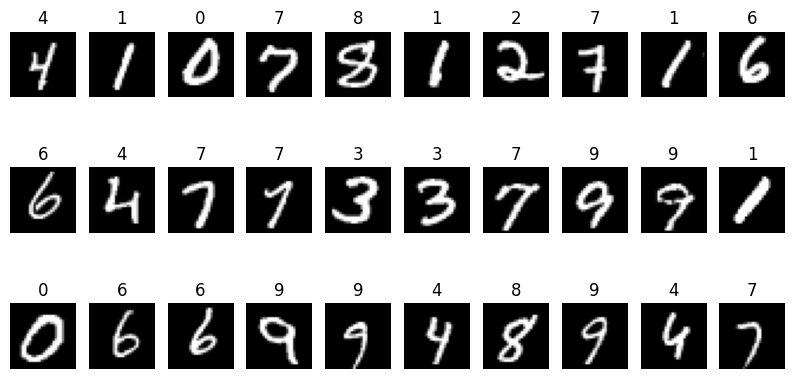

In [7]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1

plt.show()

In [8]:
train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [9]:
class MLP(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=512)(x)
    x = nn.activation.swish(x)
    x = nn.Dense(features=10)(x)
    return x

In [10]:
model = MLP()

In [11]:
key1, key2 = random.split(random.PRNGKey(0))
random_flattened_image = random.normal(key1, (28*28*1,))
params = model.init(key2, random_flattened_image) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

{'params': {'Dense_0': {'bias': (512,), 'kernel': (784, 512)},
  'Dense_1': {'bias': (10,), 'kernel': (512, 10)}}}

In [12]:
print(model.tabulate(key2, random_flattened_image))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[784] │ float32[10]  │                          │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[784] │ float32[512] │ bias: float32[512]       │
│         │        │              │              │ kernel: float32[784,512] │
│         │        │              │              │                          │
│         │        │              │              │ 401,920 (1.6 MB)         │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_1 │ Dense  │ float32[512] │ float32[10]  │ bias: float32[10]        │
│         │        │              │              │ kernel: floa

In [13]:
jax.devices()

[CudaDevice(id=0)]

In [14]:
model.apply(params, random_flattened_image)

Array([ 0.43500048,  0.20896646, -0.9779189 ,  0.34475476,  0.05475453,
        0.29811147, -0.24472941, -0.30921352,  0.29454985, -0.34386015],      dtype=float32)

In [15]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [ ]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = model.apply(params, images)    # new
  log_preds = logits - jnp.expand_dims(jax.nn.logsumexp(logits, axis=1), 1)
  return -jnp.mean(targets*log_preds)

In [ ]:
@jax.jit
def update(params, x, y, epoch_number):
  loss_value, grads = jax.value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return jax.tree_util.tree_map(    # new, better suited for pytrees
      lambda p, g: p - lr * g, params, grads), loss_value

In [ ]:
num_epochs = 25

In [ ]:
@jax.jit
def batch_accuracy(params, images, targets):
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(model.apply(params, images), axis=1)    # new
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  accs = []
  for images, targets in data:
    accs.append(batch_accuracy(params, images, targets))
  return jnp.mean(jnp.array(accs))

import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = jax.nn.one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))